#### mucking about with custom trajectories - 20250225 CJH

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [59]:
class CustomTrajectory:
    def __init__(self, waypoints, duration, interpolation_type="linear", name='test'):
        self.name = name
        self.duration = duration
        self.interpolation_type = interpolation_type  # Store interpolation method
        self.time_steps = np.linspace(0, duration, int(duration / 0.01) + 1)
        self.keys = ['elevator', 'pivot', 'wrist', 'intake']
        self.servo_columns = {'intake'}  # Default servo column, can do others
        self.waypoints = dict(sorted(waypoints.items()))  # Store waypoints for later reuse
        self.trajectory = {key: [] for key in self.keys}
        self.generate_trajectory()  # Generate the initial trajectory
    
    def generate_trajectory(self):
        times = np.array(list(self.waypoints.keys()))
        for key in self.keys:
            values = np.array([self.waypoints[t][key] for t in times]).astype(float)
            if key in self.servo_columns:
                # Servo behavior: use stepwise constant values
                step_values = np.zeros_like(self.time_steps)
                for i, t in enumerate(self.time_steps):
                    step_values[i] = values[np.searchsorted(times, t, side='right') - 1]
                self.trajectory[key] = step_values.astype(float)
            else:
                # Normal interpolation
                if self.interpolation_type == "linear":
                    interp_func = interp1d(times, values, kind='linear', fill_value='extrapolate')
                elif self.interpolation_type == "cubic":
                    interp_func = CubicSpline(times, values, bc_type='natural')
                elif self.interpolation_type == "pchip":
                    interp_func = PchipInterpolator(times, values)
                else:
                    raise ValueError(f"Unsupported interpolation type: {self.interpolation_type}")
                self.trajectory[key] = interp_func(self.time_steps).astype(float)
    
    def set_interpolation_type(self, new_type):
        """ Change interpolation type and regenerate trajectory """
        self.interpolation_type = new_type
        self.generate_trajectory()  # Recompute the trajectory with new method
    
    def get_value(self, t):
        if t < 0: t = 0
        if t > self.duration: t = self.duration
        idx = np.searchsorted(self.time_steps, t)
        if idx == 0:
            return {key: float(self.trajectory[key][0]) for key in self.keys}
        elif idx >= len(self.time_steps):
            return {key: float(self.trajectory[key][-1]) for key in self.keys}
        else:
            t1, t2 = self.time_steps[idx - 1], self.time_steps[idx]
            values = {}
            for key in self.keys:
                if key in self.servo_columns:
                    values[key] = float(self.trajectory[key][idx])
                else:
                    v1, v2 = self.trajectory[key][idx - 1], self.trajectory[key][idx]
                    values[key] = float(v1 + (v2 - v1) * (t - t1) / (t2 - t1))
            return values
    
    def check_trajectory(self, wrist_safe_pivot=(-70, 70), wrist_safe_elevator=1):
        collisions = []
        for i, t in enumerate(self.time_steps):
            pivot, elevator, wrist = self.trajectory['pivot'][i], self.trajectory['elevator'][i], self.trajectory['wrist'][i]
            if wrist != 0 and not (pivot < wrist_safe_pivot[0] or pivot > wrist_safe_pivot[1] or elevator > wrist_safe_elevator):
                collisions.append(t)
        return collisions
    
    def fix_trajectory(self, wrist_safe_pivot=(-70, 70), wrist_safe_elevator=1):
        """ Adjusts the trajectory to ensure the wrist does not move until it is safe. """
        fixed_trajectory = {key: self.trajectory[key].copy().astype(float) for key in self.keys}
        
        for i, t in enumerate(self.time_steps):
            pivot, elevator, wrist = fixed_trajectory['pivot'][i], fixed_trajectory['elevator'][i], fixed_trajectory['wrist'][i]
            if wrist != 0 and not (pivot < wrist_safe_pivot[0] or pivot > wrist_safe_pivot[1] or elevator > wrist_safe_elevator):
                fixed_trajectory['wrist'][i] = fixed_trajectory['wrist'][i-1] if i > 0 else 0.0
        
        self.trajectory = fixed_trajectory
    
    def rescale_trajectory(self, new_duration):
        """ Rescales the trajectory to fit a new duration while maintaining relative timing of waypoints. """
        scale_factor = new_duration / self.duration
        new_waypoints = {t * scale_factor: v for t, v in self.waypoints.items()}
        self.duration = new_duration
        self.time_steps = np.linspace(0, new_duration, int(new_duration / 0.01) + 1)
        self.waypoints = dict(sorted(new_waypoints.items()))
        self.generate_trajectory()

    
    def visualize_trajectory(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = {'elevator': 'blue', 'pivot': 'red', 'wrist': 'green', 'intake': 'purple'}
        limits = {'elevator': (0, 2), 'pivot': (-45, 135), 'wrist': (-90, 180), 'intake': (-5, 5)}
        
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Elevator', color=colors['elevator'])
        ax.plot(self.time_steps, self.trajectory['elevator'], color=colors['elevator'], label='Elevator')
        ax.set_ylim(limits['elevator'])
        ax.tick_params(axis='y', labelcolor=colors['elevator'])
        
        ax2 = ax.twinx()
        ax2.set_ylabel('Pivot', color=colors['pivot'])
        ax2.plot(self.time_steps, self.trajectory['pivot'], color=colors['pivot'], label='Pivot')
        ax2.set_ylim(limits['pivot'])
        ax2.tick_params(axis='y', labelcolor=colors['pivot'])
        
        ax3 = ax.twinx()
        ax3.spines['right'].set_position(('outward', 60))
        ax3.set_ylabel('Wrist', color=colors['wrist'])
        ax3.plot(self.time_steps, self.trajectory['wrist'], color=colors['wrist'], label='Wrist')
        ax3.set_ylim(limits['wrist'])
        ax3.tick_params(axis='y', labelcolor=colors['wrist'])
        
        ax4 = ax.twinx()
        ax4.spines['right'].set_position(('outward', 120))
        ax4.set_ylabel('Intake', color=colors['intake'])
        ax4.plot(self.time_steps, self.trajectory['intake'], color=colors['intake'], label='Intake')
        ax4.set_ylim(limits['intake'])
        ax4.tick_params(axis='y', labelcolor=colors['intake'])

        fig.suptitle(f'Plot of trajectory "{self.name}"', y=.95)
        fig.tight_layout()
        plt.show()
    
    def sparkline(self, length=50):
          blocks = "▁▂▃▄▅▆▇█"
          colors = {'elevator': '\033[34m', 'pivot': '\033[31m', 'wrist': '\033[32m', 'intake': '\033[35m'}
          limits = {'elevator': (0, 2), 'pivot': (-45, 135), 'wrist': (-90, 180), 'intake': (-5, 5)}
          
          spark_lines = []
          for key in self.keys:
              min_val, max_val = limits[key]
              normalized = np.interp(self.trajectory[key], [min_val, max_val], [0, 7]).astype(int)
              line = ''.join(blocks[val] for val in normalized[::len(normalized)//length])
              spark_lines.append(f"{colors[key]}{line}\033[0m")
          
          return '\n'.join(spark_lines)


{'elevator': 1.65, 'pivot': 30.0, 'wrist': 90.0, 'intake': -3.0}
Collisions: [np.float64(1.74), np.float64(1.75), np.float64(1.76), np.float64(1.77), np.float64(1.78), np.float64(1.79), np.float64(1.8), np.float64(1.81), np.float64(1.82), np.float64(1.83), np.float64(1.84), np.float64(1.85), np.float64(1.86), np.float64(1.87), np.float64(1.8800000000000001), np.float64(1.8900000000000001), np.float64(1.9000000000000001), np.float64(1.9100000000000001), np.float64(1.92), np.float64(1.93), np.float64(1.94), np.float64(1.95), np.float64(1.96), np.float64(1.97), np.float64(1.98), np.float64(1.99)]


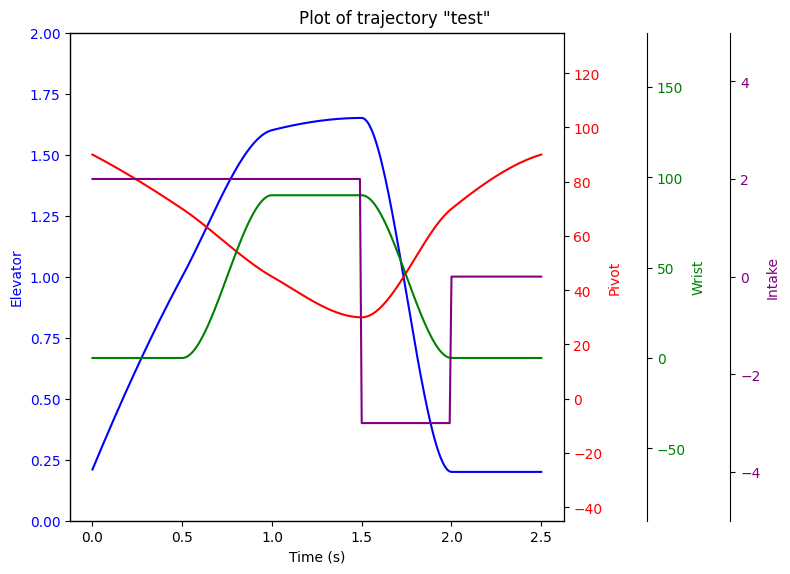

Sparkline:
▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆
▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃
▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▂▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▄▄


In [65]:
# Example Usage:
waypoints = {
    0: {'elevator': 0.21, 'pivot': 90, 'wrist': 0, 'intake': 2},  # start 
    0.5: {'elevator': 1.0, 'pivot': 70, 'wrist': 0, 'intake': 2},  # get to safe wrist
    1: {'elevator': 1.6, 'pivot': 45, 'wrist': 90, 'intake': 2},  # get to safe wrist
    1.5: {'elevator': 1.65, 'pivot': 30, 'wrist': 90, 'intake': -3},  # move wrist while finishing initial setup
    2: {'elevator': 0.2, 'pivot': 70, 'wrist': 0, 'intake': 0},  # come down to score
    2.5: {'elevator': 0.2, 'pivot': 90, 'wrist': 0, 'intake': 0},  # come down to score
}
trajectory = CustomTrajectory(waypoints, duration=2.5, interpolation_type="pchip")
print(trajectory.get_value(1.5))
print("Collisions:", trajectory.check_trajectory())
trajectory.visualize_trajectory()
print(r"Sparkline:")
print(trajectory.sparkline())

In [61]:
trajectory.get_value(.33)

{'elevator': 0.8422568,
 'pivot': 72.95486152173913,
 'wrist': 45.154889999999995,
 'intake': 2.0}

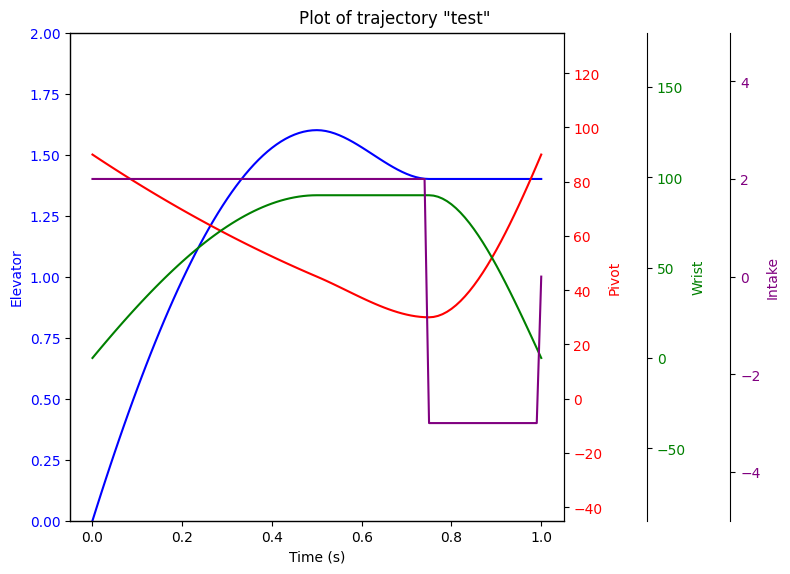

In [62]:
trajectory.rescale_trajectory(new_duration=1)
trajectory.visualize_trajectory()

In [63]:
trajectory.fix_trajectory()

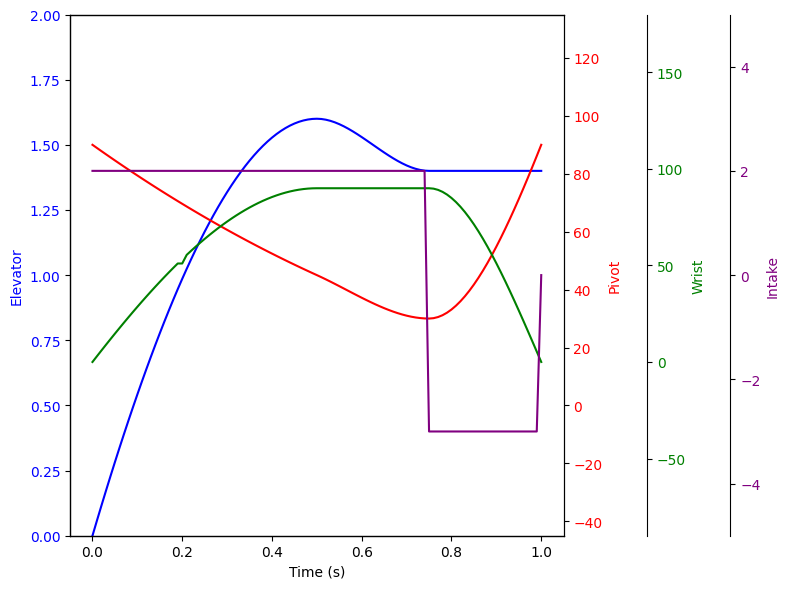

In [56]:
trajectory.visualize_trajectory()